# 01_Perturbation-Based
## 20 min

2022-02-18 09:46:38.977822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-18 09:46:40.674716: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-18 09:46:40.675764: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-18 09:46:40.775713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-02-18 09:46:40.775744: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-02-18 09:46:40.778843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.

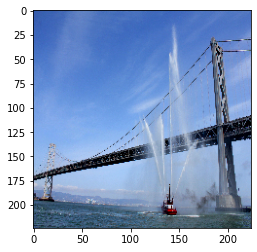

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=True
)
IMAGE_PATH = "Fireboat.jpg"
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = (np.array([img]), None)
plt.imshow(img/255)

## 1. Occlusion Sensitivity

2022-02-17 18:36:56.532335: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-17 18:36:56.552812: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3200025000 Hz
2022-02-17 18:36:57.458939: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-17 18:36:57.727029: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-17 18:36:57.729554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


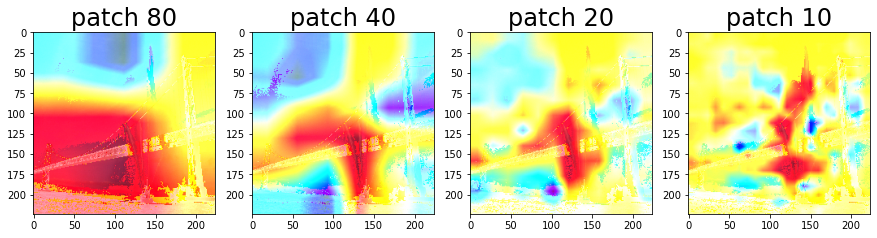

In [2]:
# Import explainer
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

fire_boat_class_index = 554

# Instantiation of the explainer
explainer = OcclusionSensitivity()

patch_size = [80, 40, 20, 10]
# Compute Occlusion Sensitivity for each patch_size
fig = plt.figure(figsize=(15, 10))
for i, patch in enumerate(patch_size):
    output_patch = explainer.explain(data, model, fire_boat_class_index, patch)
    # plot output
    plt.subplot(1,4,i+1)
    plt.imshow(output_patch)
    plt.title(f'patch {patch}', fontsize=24)
plt.show()